In [54]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F

import torchvision 

In [55]:
SEED = 0
DATAPATH = "data/mnist"
OUTPATH = "output/01"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
os.makedirs(OUTPATH, exist_ok=True)

In [57]:
n_epochs = 10

batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
val_freq = 1

in_dim = 784 #28*28 
hidden_dim = 100
out_dim = 10


In [58]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [59]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ])

In [60]:
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = pd.read_csv(os.path.join(root))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data.iloc[idx, 1:].values.astype(np.float32).reshape(28, 28)
        label = self.data.iloc[idx, 0]
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [61]:
# dataset_train = MNISTDataset(os.path.join(DATAPATH, "train.csv"))
# dataset_test = MNISTDataset(os.path.join(DATAPATH, "test.csv"))

# data_loader_train = DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
# data_loader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)

dataset_train =   torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

data_loader_train = torch.utils.data.DataLoader(dataset_train,
  batch_size=batch_size_train, shuffle=True)


dataset_test =  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
data_loader_test = torch.utils.data.DataLoader(dataset_test,
  batch_size=batch_size_test, shuffle=False)

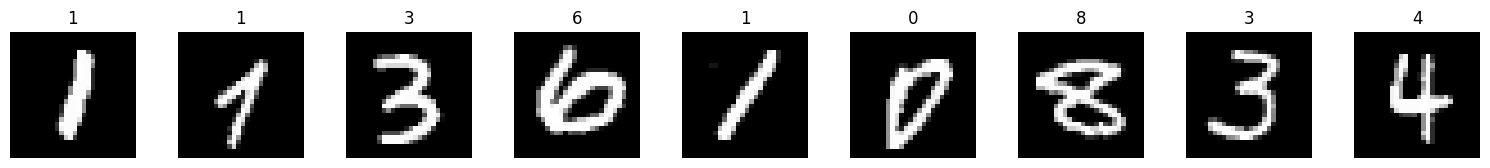

In [62]:
fig = plt.figure(figsize=(15, 5))


for i in range(n:=9):
    idx = random.randint(0, len(dataset_train))
    plt.subplot(1,n,i+1)
    plt.imshow(dataset_train[idx][0].squeeze(), cmap='gray')
    plt.title(f"{dataset_train[idx][1]}")

    plt.tight_layout()
    plt.axis('off')

In [63]:
class FeedForwardNN(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.layer1 = torch.nn.Linear(in_dim, hidden_dim)
    self.layer2 = torch.nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    return F.log_softmax(self.layer2(x), dim=1)

In [64]:
model = FeedForwardNN(in_dim, hidden_dim, out_dim)
model.to(DEVICE)

FeedForwardNN(
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=10, bias=True)
)

In [65]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.NLLLoss()

In [66]:
train_stats = {
    "step": [],
    "epoch_loss": [],
    "iter_loss": [],
}   

test_stats = {
    "step": [],
    "epoch_loss": [],
    "iter_loss": [],
    "tp": [],
}

In [67]:
model.train()
for epoch in range(n_epochs):
    train_loss = 0.0
    for idx, data in enumerate(data_loader_train):
        img, label = data
        img.to(DEVICE)
        label.to(DEVICE)

        img = img.view(-1, 28*28)
        img, label = img.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()

        output = model(img)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_stats["step"].append(epoch * len(data_loader_train) + idx)
        train_stats["iter_loss"].append(loss.item())


    train_loss /= len(data_loader_train)
    print(f"[TRAIN] Epoch: {epoch}/{n_epochs}, Loss: {train_loss:.4f}")
    if epoch % val_freq == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for idx, data in enumerate(data_loader_test):
                img, label = data
                img.to(DEVICE)
                label.to(DEVICE)

                img = img.view(-1, 28*28)
                img, label = img.to(DEVICE), label.to(DEVICE)

                output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item()

                test_stats["iter_loss"].append(loss.item())

                _, predicted = torch.max(output, 1)
                tp = (predicted == label).sum().item()

                test_stats["step"].append(epoch * len(data_loader_test) + idx)
                test_stats["tp"].append(tp)
            
            val_loss /= len(data_loader_test)
            print(f"[VAL] Epoch: {epoch}/{n_epochs}, Loss: {val_loss:.4f}")
        model.train()

    # Save
    if epoch == 0 or train_loss < min(train_stats["epoch_loss"]):
        torch.save(model.state_dict(), os.path.join(OUTPATH, "best.pt"))
    torch.save(model.state_dict(), os.path.join(OUTPATH, "last.pt"))

    train_stats["epoch_loss"].append(train_loss)
    test_stats["epoch_loss"].append(val_loss)

print("Finished Training.")

[TRAIN] Epoch: 0/10, Loss: 0.4513
[VAL] Epoch: 0/10, Loss: 0.2671
[TRAIN] Epoch: 1/10, Loss: 0.2430
[VAL] Epoch: 1/10, Loss: 0.2075
[TRAIN] Epoch: 2/10, Loss: 0.1912
[VAL] Epoch: 2/10, Loss: 0.1709
[TRAIN] Epoch: 3/10, Loss: 0.1583
[VAL] Epoch: 3/10, Loss: 0.1451
[TRAIN] Epoch: 4/10, Loss: 0.1357
[VAL] Epoch: 4/10, Loss: 0.1299
[TRAIN] Epoch: 5/10, Loss: 0.1191
[VAL] Epoch: 5/10, Loss: 0.1179
[TRAIN] Epoch: 6/10, Loss: 0.1062
[VAL] Epoch: 6/10, Loss: 0.1062
[TRAIN] Epoch: 7/10, Loss: 0.0956
[VAL] Epoch: 7/10, Loss: 0.1017
[TRAIN] Epoch: 8/10, Loss: 0.0873
[VAL] Epoch: 8/10, Loss: 0.0940
[TRAIN] Epoch: 9/10, Loss: 0.0801
[VAL] Epoch: 9/10, Loss: 0.0917
Finished Training.


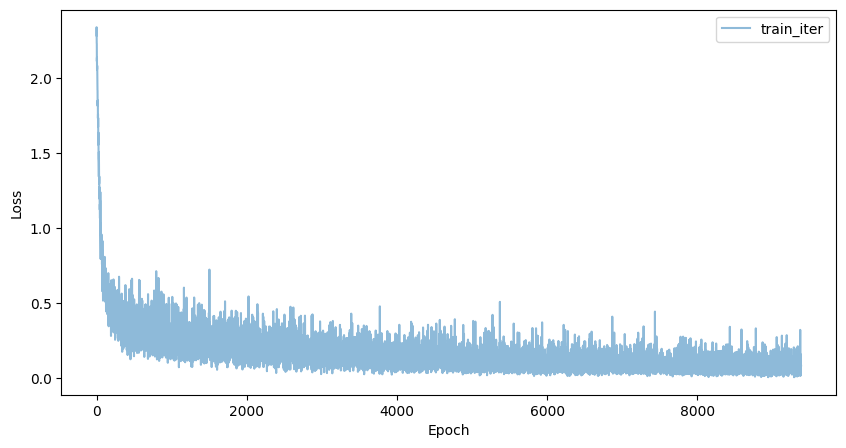

Best model loss: 0.0800664626490841 at epoch 9
Accuracy: 9.5864


In [69]:
fig = plt.figure(figsize=(10, 5))
# plt.plot(train_stats["epoch_loss"], label="train")
# plt.plot(test_stats["epoch_loss"], label="test")
plt.plot(train_stats["iter_loss"], label="train_iter", alpha=0.5)
# plt.plot(test_stats["iter_loss"], label="test_iter", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print(f"Best model loss: {min(train_stats['epoch_loss'])} at epoch {np.argmin(train_stats['epoch_loss'])}")
print(f'Accuracy: {np.sum(test_stats["tp"])/len(dataset_test)}')
